# Initial data exploration

Imports and constants.

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io

Since pahtlib has some problems when working with jupyter notebooks, we'll use os package.

In [2]:
# data_images_path = pathlib.Path(__file__).parent.parent.parent / 'data' / 'raw' 
# data_csv_path = data_images_path / 'train_info.csv'
data_images_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw')
data_csv_path = os.path.join(data_images_path, 'all_data_info.csv')

In [4]:
painting_data = pd.read_csv(data_csv_path)

Let's explore our data a little bit.

In [5]:
painting_data

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


In [13]:
painting_data['artist'].value_counts(normalize=False, dropna=False).index

Index(['Pablo Picasso', 'Giovanni Battista Piranesi', 'Pierre-Auguste Renoir',
       'Ivan Aivazovsky', 'Albrecht Durer', 'Zdislav Beksinski', 'Ilya Repin',
       'Gustave Dore', 'John Singer Sargent', 'Rembrandt',
       ...
       'The foxes have holes', 'Snowstorm', '10.7.06',
       'From Rainday on a Rainy Day', 'Evening', 'Fourth Station',
       '27 (Stone)', 'The Pont Molle', 'Beyit',
       'Corby Viaduct, the Newcastle and Carlisle Railway  '],
      dtype='object', length=2319)

This time, we'll focus on artists; there are over 2300 of them but we will classify only the most popular ones. We'll decide on a number later, but a good starting point would be about 50.

Since we'll rely on image data only, we won't need the whole dataset.

As a reminder, our goal is to classify paintings by their style, so that's the only thing that will be useful to us, as at a later stage while using the app, we won't have the rest of the information available (only pictures taken by phone camera). With just a quick glance, we can already identify a few problems:
- Really big discrepancies between classes; we'll have to either limit the number of instances per class or decide on some arbitrary number of classes to classify from.
- Big granularity between classes; to someone who's not an art expert, some of these classes can be easily classifiable as a single class, for example Baroqe and Rococo (which is an extension of Baroque), Neoclassicism and Academicism (which is a combination of the former with Romanticism) and possibly, many more.

Since the amount of data is really large and we'll be expanding the scope of the project as we go, we should start with a piece of data, and add more as we migrate to AWS S3.

For now, let's see whether points made above still stand with approximately 1/4th of data. 

In [19]:
top_50_artists_mask = painting_data['artist'].isin(painting_data['artist'].value_counts().head(50).index)

painting_data_reduced = painting_data[top_50_artists_mask][['artist', 'new_filename']]

In [20]:
painting_data_reduced

,artist,new_filename
14,Ivan Aivazovsky,99442.jpg
28,Gustave Dore,7486.jpg
29,Gustave Dore,35766.jpg
34,Gustave Dore,31977.jpg
49,Utagawa Kuniyoshi,99733.jpg
...,...,...
103121,Zinaida Serebriakova,59780.jpg
103124,Odilon Redon,98648.jpg
103149,Erte,45891.jpg
103152,James Tissot,89443.jpg


In [23]:
painting_data_reduced['artist'].value_counts(normalize=False, dropna=False).head(5)

Giovanni Battista Piranesi    500
John Singer Sargent           500
Ilya Repin                    500
Zdislav Beksinski             500
Gustave Dore                  500
Name: artist, dtype: int64

In [16]:
styles_to_classify = painting_data_reduced['style'].value_counts().reset_index(name="count").query("count > 1000")["index"]

styles_bool_mask = painting_data_reduced['style'].isin(styles_to_classify)

In [25]:
images_array = []
labels_array = []

for artist in top_50_artists_mask:
    concatenate_images = painting_data_reduced[painting_data_reduced['artist'] == artist]['new_filename'].values
    concatenate_labels = painting_data_reduced[painting_data_reduced['artist'] == artist]['artist'].values
    images_array = np.append(images_array, concatenate_images)
    labels_array = np.append(labels_array, concatenate_labels)    

KeyboardInterrupt: 

In [ ]:
images_array[:6], labels_array[:6]

Let's see one of the images and its label; we'll see Ukiyo-e since it's easily distinguisable from the others:

In [ ]:
sample_image_path = os.path.join(data_images_path, images_array[-290])
io.imshow(sample_image_path)

print(labels_array[-290])

In [ ]:
len(images_array)

As you can see, the image has high pixel count and we won't need it in this form; all of the images will have to be the same size, so we need to come up with appropriate preprocessing strategy.

Last but not least, let's copy over all the images we need to a different directory  where they'll be preprocessed; we'll rename them with their labels and consecutive image number.

In [21]:
for index, (image, label) in enumerate(zip(images_array, labels_array)):
    current_file = os.path.join(data_images_path, image)
    new_file_path = os.path.join(os.path.dirname(data_images_path), 'interim', f'{index}_{label}.jpg')
#     print(current_file, new_file_path)
    shutil.copy(current_file, new_file_path)
    

We have succesfully chosen the files for our analysis, renamed them and copied over to the appropriate directory; let's take advantage of last assigned variable inside the loop being available outside of it, and check the last saved file:

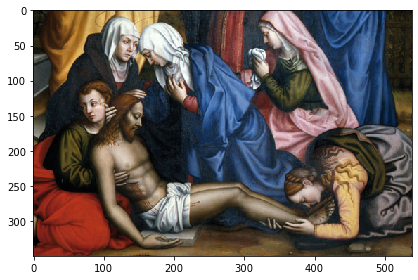

In [22]:
io.imshow(new_file_path)

We could actually preprocess all the files here, but it's best if the whole process is incorporated either in our neural network or even better, in a custom pipeline, which we'll do sometime soon. 